Let's get some input data from the [VecNet digital library](https://dl.vecnet.org/files/v118rd54q).

Specifically, we're going to look at the weather station in Kisumu, Kenya.

More information on the meaning of columns can be found [here](ftp://ftp.ncdc.noaa.gov/pub/data/gsod/readme.txt).

In [1]:
%matplotlib inline

import datetime
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Read GSOD-formatted file
weather_df = pd.read_csv(
    os.path.join('data', 'CDO5111355911589Kisumu1980-2011.csv'),
    skipinitialspace=True
)

weather_df.columns = [x.strip() for x in weather_df.columns.values]  # trim whitespace
weather_df = weather_df[['YEARMODA', 'TEMP', 'DEWP', 'PRCP']]  # columns to use

# Parse date
weather_df.index = pd.to_datetime(weather_df.YEARMODA, format='%Y%m%d').rename('date')

def F_to_C(temp_F):
    return (temp_F - 32.0) / 1.8

def inch_to_mm(rain_in):
    return rain_in * 25.4

def relative_humidity(x):
    if x.DEWP == 9999.9 or x.TEMP == 9999.9:  # missing data code
        return np.nan
    T_C = F_to_C(x.TEMP)
    DP_C = F_to_C(x.DEWP)
    return math.exp((17.625*DP_C) / (243.04+DP_C)) / math.exp((17.625*T_C) / (243.04+T_C))

def decode_rainfall_string(x):
    rain_in = float(x[:-1])
    if rain_in == 99.99:  # missing data code
        return np.nan
    return inch_to_mm(rain_in)

# Generate derived values + fill missing data with usable value
weather_df['mean_temp_C'] = weather_df.TEMP.map(F_to_C)
weather_df['rel_humid'] = weather_df.apply(relative_humidity, axis=1).fillna(0.7)
weather_df['rain_mm'] = weather_df.PRCP.map(decode_rainfall_string).fillna(0)

print(weather_df.head())

            YEARMODA  TEMP  DEWP   PRCP  mean_temp_C  rel_humid  rain_mm
date                                                                    
1980-01-01  19800101  72.5  62.6  0.31G    22.500000   0.710922    7.874
1980-01-02  19800102  68.9  58.4  0.00G    20.500000   0.692174    0.000
1980-01-03  19800103  66.2  55.4  0.00G    19.000000   0.681762    0.000
1980-01-04  19800104  66.2  56.8  0.00G    19.000000   0.717196    0.000
1980-01-05  19800105  74.1  56.8  0.00D    23.388889   0.547884    0.000


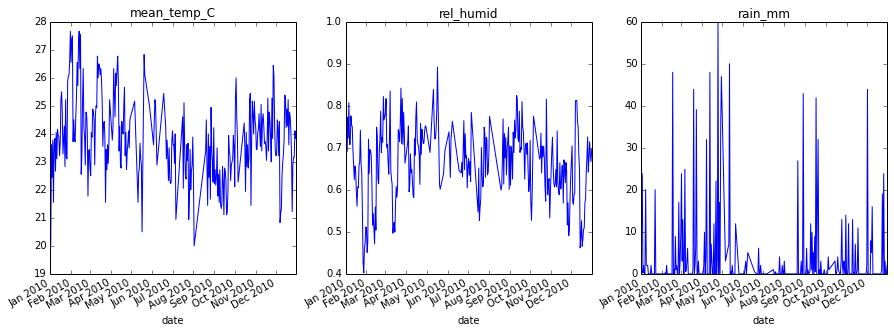

In [2]:
f, axs = plt.subplots(1, 3, figsize=(15, 5))
year_2010 = slice(datetime.date(2010, 1, 1), datetime.date(2010, 12, 31))
for i, channel in enumerate(['mean_temp_C', 'rel_humid', 'rain_mm']):
    weather_df.loc[year_2010, channel].plot(ax=axs[i])
    axs[i].set_title(channel)

Let's input this weather data into the temporary rainfall larval habitat model.

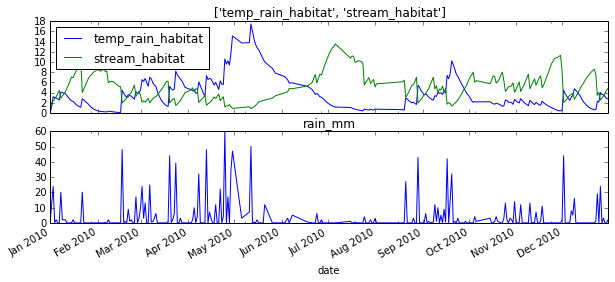

In [10]:
from habitat import TemporaryRainfallHabitatModel, SeasonalStreamHabitatModel

model1 = TemporaryRainfallHabitatModel(accumulation_scale=0.1,
                                       evaporation_scale=0.1)  # 1/0.1 = 10 days

model2 = SeasonalStreamHabitatModel(accumulation_scale=1,
                                    evaporation_scale=0.05,  # 20d
                                    stream_decay_scale=0.2,  # 5d
                                    flow_threshold=2,
                                    max_capacity=40)
                                    
weather_df['temp_rain_habitat'] = 0
weather_df['stream_habitat'] = 0

for date, weather in weather_df.loc[year_2010].iterrows():
    model1.update(weather)
    model2.update(weather)
    weather_df.loc[date, 'temp_rain_habitat'] = model1.get_current_capacity()
    weather_df.loc[date, 'stream_habitat'] = model2.get_current_capacity()

fig, axs = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
for i, channel in enumerate([['temp_rain_habitat', 'stream_habitat'], 'rain_mm']):
    weather_df.loc[year_2010, channel].plot(ax=axs[i])
    axs[i].set_title(channel)